In [1]:
#!/home/neil.lu/.conda/envs/ringdown/bin/python
# coding: utf-8
# %%


import numpy as np
import qnm_filter
import qnm
import random
import argparse
from scipy.special import logsumexp
from pathlib import Path
import glob
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as pl

In [2]:
modes_inj = ['220']
modes_filt = ['200']
index = 0

duration = 4
fsamp = 4096

In [25]:
def plotter(likelihood, credible, name):
    pl.rc('figure', figsize=(6.1, 6.6))
    fig, ax = pl.subplots()
    contours = ax.contourf(mass_grid, chi_grid, likelihood, 20, cmap='Spectral',
                           origin='lower', alpha=0.6, linestyles='--')
#     dotted = ax.contour(mass_grid, chi_grid, likelihood, [credible], colors = 'red', \
#                        linestyles ='--')
#     maximum = ax.contour(mass_grid, chi_grid, likelihood, [np.max(likelihood)], colors = 'green', \
#                        linestyles ='-', label='Maximum likelihood')
    print(np.argmax(likelihood))

    # coloarbar
    cbar=fig.colorbar(contours, orientation="horizontal", 
                      pad=0.15, format='%3.2f')
    cbar.set_label(r'$\ln$ likelihood', fontsize=15)
    cbar.set_ticks(np.linspace(np.min(likelihood), np.max(likelihood), 5))

    pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
    pl.title(name+"")
    pl.ylabel(r'$\chi_f$', fontsize=13)
    pl.show()
#     pl.savefig(str(Path().absolute())+"/"+name+".png")

    # ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

def signal_creator(amp_scale):
    global signal, signal_inj, mass, t_range, signalH_noise, mass_in_solar, chi_inject
    # Remnant properties
    mass_in_solar = 50 #random.uniform(30, 90) 
    chi_inject = 0.7 #random.uniform(0.0, 0.95) 
    injected = (mass_in_solar, chi_inject)
    mass = qnm_filter.Filter.mass_unit(injected[0]) #unit of time
    
    # Complex frequency of the modes
    omega_dict = {}
    for mode in modes_inj:
    	omega_dict[mode] = qnm.modes_cache(s=-2,l=int(mode[0]),m=int(mode[1]),n=int(mode[2]))(a=injected[1])[0]

    ref_amp = 8.4 * 1e-21 * amp_scale
    t_range = np.arange(-duration/2, duration/2, 1/fsamp)
    
    # Creating the signal
    signal_inj = np.zeros(len(t_range))
    for keys, omega in omega_dict.items():
        phase =  0 #random.uniform(0, 2*np.pi) 
        amp = ref_amp * 1 #random.uniform(0.7, 1.3) 
        temp_signal = np.real(amp * np.exp(1j*phase) * np.exp(-1j * omega * np.abs(t_range / mass)))
        signal_inj = np.add(signal_inj, temp_signal)
    
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo(
    "H1", fsamp, duration, start_time=-duration / 2)
    signalH_noise = qnm_filter.bilby_get_strain(bilby_ifo, 0.0)
    signal = signal_inj + signalH_noise

def injection_evidence():
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(signalH_noise, index=t_range)
    fit.condition_data('original_data', **input)
    fit.condition_data('pure_noise', **input)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    #Injected analysis
    model_list_inj = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_inj]
    
    likelihood_inj, evidence_inj = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 14,
                                                 model_list=model_list_inj)
#     credible_inj = qnm_filter.find_credible_region(likelihood_inj, target_probability = 0.95)
#     occams_inj = np.count_nonzero(likelihood_inj>credible_inj)/len(mass_grid.flatten())

    #Underfiltered analysis
    model_list_filt = [(int(m[0]),int(m[1]),int(m[2]),'p') for m in modes_filt]
    
    likelihood_filt, evidence_filt = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 14,
                                                 model_list=model_list_filt)
#     credible_filt = qnm_filter.find_credible_region(likelihood_filt, target_probability = 0.95)
#     occams_filt = np.count_nonzero(likelihood_filt>credible_filt)/len(mass_grid.flatten())

    plotter(likelihood_inj, None, "injected")
    plotter(likelihood_filt, None, "filtered")

    nofilter = logsumexp(
        np.array(
            [fit.compute_likelihood(apply_filter=False)]
            * len(massspace)
            * len(chispace)
        )
    )
    
    fit.pure_nr = {}
    fit.pure_nr["H1"] = qnm_filter.RealData(signal_inj, index=t_range, ifo="H1")
    fit.condition_data('pure_nr', **input)
    SNRtot_MF = fit.compute_SNR(
        fit.truncate_data(fit.original_data)["H1"],
        fit.truncate_data(fit.pure_nr)["H1"],
        "H1",
        False,
    )
    # print(SNRtot_MF)
    return np.array([SNRtot_MF, evidence_inj, evidence_filt, nofilter, 
                    mass_in_solar, chi_inject])

In [28]:
# Creating signal
amp_scale = random.uniform(0.1, 2)
signal_creator(amp_scale)

# Parameters
delta_mass = 5
delta_chi = 0.01
massspace = np.arange(1, 160, delta_mass) #[1,160]
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)
input = dict(segment_length=0.2, 
             srate=4096, 
             t_init=3.0*mass,
#              flow = 20,
             remove_mean = True,
             trim = 0.1,
            )

2346


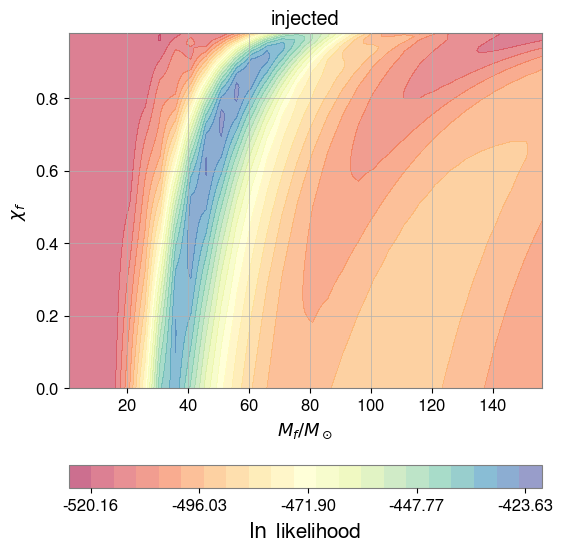

3144


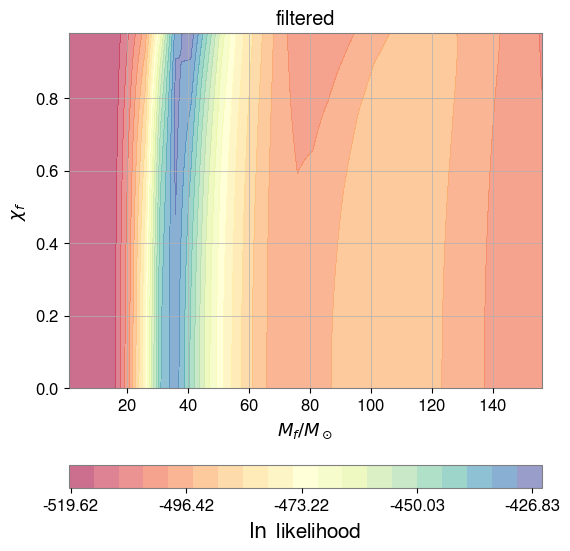

In [27]:
# Analysis flow = 20
result = injection_evidence()

2314


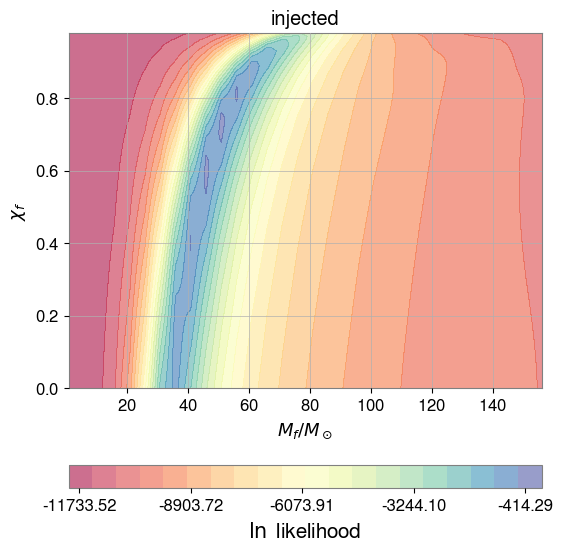

3144


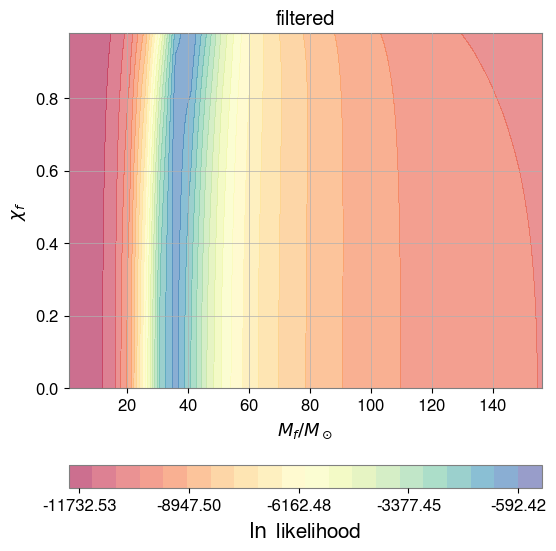

In [29]:
# Analysis no flow
result = injection_evidence()